# DC$\pi$BO - ECON

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../src/")
sys.path.append("../..")

from src.examples.example_setups import setup_econ_SEM
from src.utils.sem_utils.real_sems import EconSEM
from src.utils.sem_utils.sem_estimate import build_sem_hat

from src.experimental.experiments import run_methods_replicates
from src.experimental.analyse_results import get_relevant_results, elaborate, gap_metric_standard, get_common_initial_values, get_converge_trial
from src.utils.plotting import plot_expected_opt_curve_paper

from src.methods.bo import BO
from src.methods.dcbo import DCBO
from src.methods.pibo import PIBO
from src.methods.dcpibo import DCPIBO

from matplotlib.pyplot import rc
import numpy as np
from scipy import stats
import random
# import csv
import pandas as pd
# from collections import OrderedDict
# from src.utils.utilities import powerset
# from src.utils.sequential_intervention_functions import get_interventional_grids
from copy import deepcopy

random.seed(42)

## Utility Functions

In [2]:
def power_list(input_list, exponent):
    '''Raises each element of the given input_list to the desired exponent'''
    
    return_list = []
    
    for element in input_list:
        if element >= 0:
            raised_element = element**exponent
        else:
            raised_element = -(abs(element)**exponent)
        return_list.append(raised_element)
        
    return return_list

In [3]:
def compute_statistics(y_function, standard_deviation):
    '''Computes all the necessary lists associated to the Normal Distribution'''
    
    return_variates = []
    return_amps = []
    return_pdfs = []
    
    for mean in y_function:
        return_variates.append(stats.norm.rvs(mean, standard_deviation, 10))
        
        amp = np.linspace(mean-5*standard_deviation, mean+5*standard_deviation, 10)
        return_amps.append(amp)
        
        return_pdfs.append(stats.norm.pdf(amp, mean, standard_deviation))
    
    return return_variates, return_amps, return_pdfs

In [4]:
def normalise_pdfs(pdfs_list):
    '''Normalises the PDFs between 0 and 1'''
    
    return_normalised_pdfs_list = []
    
    for pdf_list in pdfs_list:
        temp_list = []
        
        pdf_min = min(pdf_list)
        pdf_max = max(pdf_list)
        
        for pdf_value in pdf_list:
            temp_list.append(round((pdf_value-pdf_min)/(pdf_max-pdf_min),2))
        
        return_normalised_pdfs_list.append(temp_list)
        
    return return_normalised_pdfs_list

In [5]:
def regret_priors(start_prior):
    '''Adds regret'''
    
    return_raised_priors = []
    
    for i in range(1,N+1):
        temp = []
        gamma = beta/i
        
        for p_list in start_prior:
            temp.append(power_list(p_list, gamma))
            
        return_raised_priors.append(temp)
    
    return return_raised_priors

In [6]:
def predict_optima_regret(iterations, time_steps, regret_priors, normalised_pdfs):
    '''Computes the prediction for each time-step and each iteration, according to the effect of gamma (regret)'''
    
    return_predictions = []
    
    for iteration in range(iterations):
        temp = []
        
        for time_step in range(time_steps):
            if(min(regret_priors[iteration][time_step])+max(regret_priors[iteration][time_step]))<0:
                optimum = min(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
            else:
                optimum = max(np.multiply(regret_priors[iteration][time_step], normalised_pdfs[time_step]))
                              
            temp.append(optimum)
                              
        return_predictions.append(temp)
                              
    return return_predictions

## Constants and such

In [7]:
T = 3
t_axis = np.linspace(1,T,T,dtype=int)
N = 10
std = 0.1
beta = 1

## Setup

### Import and Clean Data

In [8]:
GDP = pd.read_csv('../../data/economic_data/GDP.csv')
INF = pd.read_csv('../../data/economic_data/INF.csv')
TAX = pd.read_csv('../../data/economic_data/TAX.csv')
UN = pd.read_csv('../../data/economic_data/UN.csv')

In [9]:
GDP = GDP[["LOCATION", "TIME", "Value"]]
INF = INF[["LOCATION", "TIME", "Value"]]
TAX = TAX[["LOCATION", "TIME", "Value"]]
UN = UN[["LOCATION", "TIME", "Value"]]

In [10]:
new_df2 = pd.merge(GDP, INF, how='left', on=['LOCATION','TIME'])
new_df3 = pd.merge(new_df2, TAX,  how='left', on=['LOCATION','TIME'])
new_df4 = pd.merge(new_df3, UN,  how='left', on=['LOCATION','TIME'])

 /tmp/ipykernel_1063/2640134892.py:3: FutureWarning:Passing 'suffixes' which cause duplicate columns {'Value_x'} in the result is deprecated and will raise a MergeError in a future version.


In [11]:
new_df4.columns = ['LOC', 'TIME', 'GDP', 'INF', 'TAX', 'UN']
data = new_df4[new_df4['TIME'] > 2017]
data = data[data['TIME'] < 2023]

In [12]:
data = data.dropna()
data = data.reset_index(drop=True)

In [13]:
country_list = []
for i in range(10):
    time = 2018 + i
    country_list.append(list(data[data['TIME'] == time]['LOC']))

In [14]:
np.unique(data['LOC'])

array(['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CHL', 'COL', 'CRI', 'CZE',
       'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN',
       'IRL', 'ISL', 'ISR', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA',
       'MEX', 'NLD', 'NOR', 'NZL', 'POL', 'PRT', 'SVK', 'SVN', 'SWE',
       'TUR', 'USA'], dtype=object)

In [15]:
data['GDP%'] = np.nan
data['log_U'] = np.nan
data['TAX%'] = np.nan

for i, row in data.iterrows():
    if i > 0:
        perc_change_GDP = ((list(data['GDP'])[i] 
                           - list(data['GDP'])[i-1])/list(data['GDP'])[i-1])*100

        perc_change_tax = ((list(data['TAX'])[i]*list(data['GDP'])[i] 
                           - list(data['TAX'])[i-1]*
                            list(data['GDP'])[i-1])/(list(data['TAX'])[i-1]*list(data['GDP'])[i-1]))*100
        
        log_U = list(data['UN'])[i]
        
        data.at[i,'GDP%'] = perc_change_GDP
        data.at[i,'log_U'] = log_U
        data.at[i,'TAX%'] = perc_change_tax

In [16]:
extracted_data = data[['LOC', 'TIME', 'GDP%', 'log_U', 'TAX%', 'INF']]
extracted_data = extracted_data.dropna()[extracted_data['TIME'] != 2018]

 /tmp/ipykernel_1063/3838321221.py:2: UserWarning:Boolean Series key will be reindexed to match DataFrame index.


In [17]:
# from sklearn import preprocessing

# min_max_scaler = preprocessing.MinMaxScaler()
# extracted_data[['GDP%', 'log_U', 'TAX%', 'INF']] = preprocessing.normalize(extracted_data[['GDP%', 'log_U', 'TAX%', 'INF']])

In [18]:
Z = np.asarray(extracted_data[['GDP%', 'TIME', 'LOC']].pivot(index = 'LOC', columns='TIME'))
Y = np.asarray(extracted_data[['log_U', 'TIME', 'LOC']].pivot(index = 'LOC', columns='TIME'))
X = np.asarray(extracted_data[['INF', 'TIME', 'LOC']].pivot(index = 'LOC', columns='TIME'))
F = np.asarray(extracted_data[['TAX%', 'TIME', 'LOC']].pivot(index = 'LOC', columns='TIME'))

Z[np.isnan(Z)] = (np.nanmax(Z)-np.nanmin(Z))/len(Z)
Y[np.isnan(Y)] = (np.nanmax(Y)-np.nanmin(Y))/len(Y)
X[np.isnan(X)] = (np.nanmax(X)-np.nanmin(X))/len(X)
F[np.isnan(F)] = (np.nanmax(F)-np.nanmin(F))/len(F)

date = np.asarray(list(extracted_data['TIME']))
observational_samples = {'Z':Z, 'Y':Y, 'X':X, 'F':F}

# Z=G
# Y=U
# X=R
# F=T

### Model:

In [19]:
parametric = False
liner_type = True

In [20]:
from src.utils.gp_utils import fit_gp

time_vector = np.tile(np.linspace(0, 37, 38), 3)[:,np.newaxis]

if parametric is False:
    model_F = fit_gp(time_vector, np.hstack(observational_samples['F'])[:,np.newaxis])

    model_X = fit_gp(time_vector, np.hstack(observational_samples['X'])[:,np.newaxis])

    model_Z = fit_gp(np.hstack((np.hstack(observational_samples['X'])[:,np.newaxis], 
                             np.hstack(observational_samples['F'])[:,np.newaxis])),  
                             np.hstack(observational_samples['Z'])[:,np.newaxis])
    
    model_Y = fit_gp(np.hstack((observational_samples['X'][:,0][:,np.newaxis], 
                             observational_samples['Z'][:,0][:,np.newaxis])),  
                             observational_samples['Y'][:,0][:,np.newaxis])
elif liner_type:
    model_F = LinearRegression().fit(time_vector, np.hstack(observational_samples['F'])[:,np.newaxis])
    model_X = LinearRegression().fit(np.hstack(observational_samples['M'])[:,np.newaxis],  
                  np.hstack(observational_samples['X'])[:,np.newaxis])

    model_Z = LinearRegression().fit(np.hstack((np.hstack(observational_samples['X'])[:,np.newaxis], 
                             np.hstack(observational_samples['F'])[:,np.newaxis])),  
                             np.hstack(observational_samples['Z'])[:,np.newaxis])

    model_Y = LinearRegression().fit(np.hstack((np.hstack(observational_samples['X'])[:,np.newaxis], 
                             np.hstack(observational_samples['Z'])[:,np.newaxis])),  
                             np.hstack(observational_samples['Y'])[:,np.newaxis])    
else:
    numpy.polyfit(numpy.log(x), y, 1)
    
functions_0 = {'Z': model_Z, 'Y': model_Y, 'X':model_X, 'F': model_F}

In [21]:
functions_0

{'Z': <GPy.models.gp_regression.GPRegression at 0x7faa6e4ac490>,
 'Y': <GPy.models.gp_regression.GPRegression at 0x7faa6e489b70>,
 'X': <GPy.models.gp_regression.GPRegression at 0x7faa6e4ad750>,
 'F': <GPy.models.gp_regression.GPRegression at 0x7faa6e48b970>}

In [22]:
X_AR = []
Z_AR = []
Y_AR = []

for i in range(observational_samples['X'].shape[0]):
    #X_AR.append(np.transpose(np.vstack((observational_samples['X'][i][:-1],  
    #                                    observational_samples['M'][i][1:],
    #                                    observational_samples['X'][i][1:]))))
    
    X_AR.append(np.transpose(np.vstack((observational_samples['X'][i][:-1],
                                        observational_samples['X'][i][1:]))))
        
    
    Z_AR.append(np.transpose(np.vstack((observational_samples['Z'][i][:-1],
                                        observational_samples['X'][i][1:],
                                        observational_samples['F'][i][1:],
                                        observational_samples['Z'][i][1:]))))
    
    
    Y_AR.append(np.transpose(np.vstack((observational_samples['Y'][i][:-1],
                                        observational_samples['Z'][i][1:],
                                        observational_samples['X'][i][1:],
                                        observational_samples['Y'][i][1:]))))

X_AR = np.vstack(X_AR)
Z_AR = np.vstack(Z_AR)
Y_AR = np.vstack(Y_AR)

if parametric is False:
    model_X_t = fit_gp(X_AR[:, :-1], X_AR[:, -1][:,np.newaxis])
    model_Z_t = fit_gp(Z_AR[:, :-1], Z_AR[:, -1][:,np.newaxis])
    model_Y_t = fit_gp(Y_AR[:, :-1], Y_AR[:, -1][:,np.newaxis])
else:
    model_X_t = LinearRegression().fit(X_AR[:, :-1], X_AR[:, -1][:,np.newaxis])
    model_Z_t = LinearRegression().fit(Z_AR[:, :-1], Z_AR[:, -1][:,np.newaxis])
    model_Y_t = LinearRegression().fit(Y_AR[:, :-1], Y_AR[:, -1][:,np.newaxis])
    
functions_t = {'Z': model_Z_t, 'Y': model_Y_t, 'X': model_X_t, 'F': model_F}

In [23]:
functions_t

{'Z': <GPy.models.gp_regression.GPRegression at 0x7faa6e4ac2e0>,
 'Y': <GPy.models.gp_regression.GPRegression at 0x7faa6e50f6d0>,
 'X': <GPy.models.gp_regression.GPRegression at 0x7faa6e4af3d0>,
 'F': <GPy.models.gp_regression.GPRegression at 0x7faa6e48b970>}

In [24]:
# it's not stuck, it just takes long to complete. 
# It eventually successfully reaches the end
init_sem, sem, dag_view, G, exploration_sets, intervention_domain, true_objective_values, optimal_interventions, all_causal_effects = setup_econ_SEM(T=T, functions_0=functions_0, functions_t=functions_t)

In [25]:
a_param = (true_objective_values[0]-true_objective_values[1])/(t_axis[0]-t_axis[1])
b_param = (true_objective_values[0]*t_axis[1]-true_objective_values[1]*t_axis[0])/(t_axis[0]-t_axis[1])

y = a_param*t_axis+b_param # the line on which I assume the optima would be

In [26]:
all_variates, all_amps, all_pdfs = compute_statistics(y, std)
all_variates_regret = regret_priors(all_variates)

all_pdfs_normalised = normalise_pdfs(all_pdfs)

predicted_optima_regret = predict_optima_regret(N, T, all_variates_regret, all_pdfs_normalised) # this are all the 𝜋s

In [27]:
manipulative_vars = list(intervention_domain.keys())
subset_obs_data = deepcopy(observational_samples)
for var in subset_obs_data.keys():
    subset_obs_data[var] = subset_obs_data[var][:,:3]

In [28]:
R=3

In [29]:
E_SEM = EconSEM(functions_0=functions_0, functions_t=functions_t)

In [30]:
results = run_methods_replicates(G=G, 
                                sem=EconSEM, 
                                make_sem_estimator=build_sem_hat, 
                                base_target_variable='Y',
                                intervention_domain = intervention_domain, 
                                methods_list = ['BO','PIBO', 'DCBO', 'DCPIBO'],
                                obs_samples = subset_obs_data,
                                exploration_sets = exploration_sets,
                                priors_regret = predicted_optima_regret,
                                total_timesteps = T,
                                number_of_trials = N, 
                                reps = R, # Number of replicates (how many times we run each method)
                                n_restart = 1,
                                save_data = False,
                                n_obs = 5, # The method samples 5 time-series for each replicate
                                num_anchor_points = 100,
                                sample_anchor_points = True,
                                controlled_experiment=False,
                                args_sem = [functions_0, functions_t],
                                manipulative_variables=manipulative_vars)

Experiment count:   0%|                                                                           | 0/3 [00:00<?, ?it/s]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  3.90it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  3.88it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.01it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  3.02it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  2.90it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.87it/s]
 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:06<00:12,  6.25s/it]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:20<00:11, 11.01s/it]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:38<00:00, 12.88s/it]



	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:05<00:11,  5.72s/it]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:18<00:10, 10.01s/it]reconstraining parameters GP_regression.rbf.variance

Experiment count:  33%|██████████████████████                                            | 1/3 [02:18<04:36, 138.17s/it]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  3.25it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  3.42it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.52it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  3.75it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  3.88it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  3.85it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:06<00:12,  6.48s/it]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:19<00:10, 10.07s/it]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:35<00:00, 11.99s/it]



	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:06<00:13,  6.51s/it]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:17<00:09,  9.12s/it]reconstraining parameters GP_regression.rbf.variance

Experiment count:  67%|████████████████████████████████████████████                      | 2/3 [04:23<02:10, 130.80s/it]


	>>>BO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  3.96it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.14it/s]reconstraining parameters GP_regression.rbf.variance
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:119: RuntimeWarning:overflow encountered in expm1
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/paramz/transformations.py:121: RuntimeWarning:overflow encountered in expm1

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.25it/s]


10

	>>>PIBO




Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:00<00:00,  4.52it/s]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:00<00:00,  4.71it/s]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.45it/s]



	>>>DCBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:05<00:10,  5.01s/it]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:14<00:07,  7.84s/it]reconstraining parameters GP_regression.rbf.variance

Time index: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.16s/it]



	>>>DCPIBO



 /mnt/c/Users/lucal/Desktop/Thesis/notebooks/MyTests/../../src/utils/dag_utils/adjacency_matrix_utils.py:26: FutureWarning:adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in divide
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/luca/miniconda3/envs/MTL_DCBO_testing/lib/python3.10/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?
why are your arrays not F order?



Time index:   0%|                                                                                 | 0/3 [00:00<?, ?it/s]reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.rbf.variance

Time index:  33%|████████████████████████▎                                                | 1/3 [00:04<00:09,  4.58s/it]reconstraining parameters GP_regression.rbf.variance

Time index:  67%|████████████████████████████████████████████████▋                        | 2/3 [00:13<00:07,  7.01s/it]reconstraining parameters GP_regression.rbf.variance

Experiment count: 100%|██████████████████████████████████████████████████████████████████| 3/3 [05:51<00:00, 117.11s/it]


## Plotting

In [31]:
plot_params = {
    "linewidth": 3,
    "linewidth_opt": 4,
    "alpha": 0.1,
    "xlim_max": N,
    "ncols": 5,
    "loc_legend": "lower right",
    "size_ticks": 20,
    "size_labels": 20,
    "xlabel": r'$\texttt{cost}(\mathbf{X}_{s,t}, \mathbf{x}_{s,t})$',
    "labels": {'DCPIBO': 'DCPIBO', 'PIBO': 'PIBO', 'DCBO': 'DCBO', 'BO': 'BO', 'True': r'$\mathbb{E} \left [Y_t \mid \textrm{do}(\mathbf{X}_{s,t}^\star = \mathbf{x}_{s,t}^\star) \right]$'},
    "colors": {'DCPIBO': 'blue', 'PIBO': 'green', 'DCBO': 'orange', 'BO': 'red', 'True': 'black'},
    "line_styles": {'DCPIBO': 'dashdot', 'PIBO': '--', 'DCBO': '-', 'BO': '-', 'True': ':'},
    "width":10
}
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amssymb}')
rc('font', family='serif')
rc('font', size=20)

In [32]:
data = get_relevant_results(results=results, replicates=R)
exp_optimal_outcome_values_during_trials, exp_per_trial_cost = elaborate(number_of_interventions=None,
                                                                                   n_replicates=R,
                                                                                   data=data,
                                                                                   best_objective_values=true_objective_values,
                                                                                   T=T)

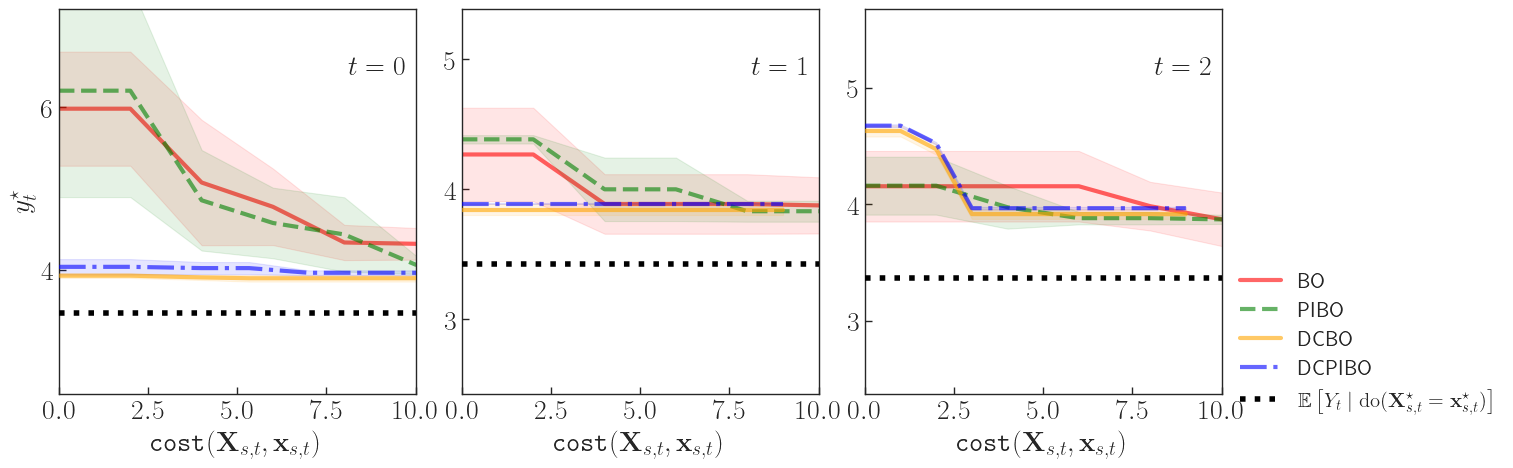

In [33]:
# Each frame corresponds to one time-slice.
plot_expected_opt_curve_paper(T,
    true_objective_values,
    exp_per_trial_cost,
    exp_optimal_outcome_values_during_trials,
    plot_params,  
    fig_size = (15,5))